<a href="https://colab.research.google.com/github/nandinib1999/edureka-assignments/blob/main/Edureka_DL_End_Course_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 - Face Mask Detection 

In [1]:
!unzip "/content/drive/MyDrive/dataset-face-mask.zip"

Archive:  /content/drive/MyDrive/dataset-face-mask.zip
  inflating: dataset/without_mask/augmented_image_87.jpg  
  inflating: dataset/without_mask/augmented_image_93.jpg  
  inflating: dataset/without_mask/augmented_image_88.jpg  
  inflating: dataset/without_mask/augmented_image_80.jpg  
  inflating: dataset/without_mask/augmented_image_81.jpg  
  inflating: dataset/without_mask/augmented_image_91.jpg  
  inflating: dataset/without_mask/augmented_image_85.jpg  
  inflating: dataset/without_mask/augmented_image_96.jpg  
  inflating: dataset/without_mask/augmented_image_83.jpg  
  inflating: dataset/without_mask/augmented_image_90.jpg  
  inflating: dataset/without_mask/augmented_image_82.jpg  
  inflating: dataset/without_mask/augmented_image_92.jpg  
  inflating: dataset/without_mask/augmented_image_86.jpg  
  inflating: dataset/without_mask/augmented_image_99.jpg  
  inflating: dataset/without_mask/augmented_image_89.jpg  
  inflating: dataset/without_mask/augmented_image_97.jpg  
 

In [2]:
import os
from PIL import Image

DATA_DIR = "/content/dataset"
classes = ["with_mask", "without_mask"]

In [3]:
def get_image_paths(path_dir, class_id):
  image_path_label = []
  for image_name in os.listdir(os.path.join(path_dir, class_id)):
    img_path = os.path.join(path_dir, class_id, image_name)
    image_path_label.append([img_path, class_id])
  return image_path_label

In [4]:
train_test_img_path = get_image_paths(DATA_DIR, classes[0])
train_test_img_path.extend(get_image_paths(DATA_DIR, classes[1]))

In [5]:
len(train_test_img_path)

1376

In [6]:
import pandas as pd

df = pd.DataFrame(train_test_img_path, columns=['image_path', 'label'])
df.head()

image_path      label
0  /content/dataset/with_mask/augmented_image_147...  with_mask
1  /content/dataset/with_mask/augmented_image_235...  with_mask
2       /content/dataset/with_mask/381-with-mask.jpg  with_mask
3       /content/dataset/with_mask/408-with-mask.jpg  with_mask
4        /content/dataset/with_mask/73-with-mask.jpg  with_mask

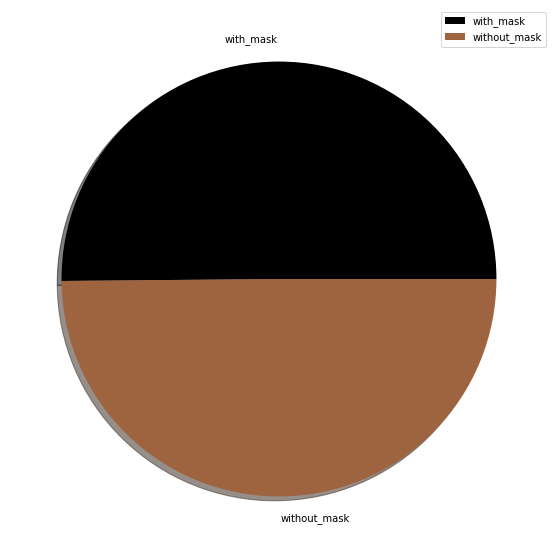

<Figure size 720x720 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots(figsize=(10, 10))
theme = plt.get_cmap('copper')
ax1.set_prop_cycle("color", [theme(1. * i / 2) for i in range(5)])
plt.figure(figsize=(10,10))
ax1.pie(df.label.value_counts(), labels=classes, shadow=True)
ax1.legend()
plt.show()

In [8]:
def visualize_imgs(df, sample_cnt):
    df = df.groupby('label',group_keys = False).apply(lambda df: df.sample(sample_cnt))
    df = df.reset_index(drop = True)
    
    for pt in range(sample_cnt):
        f, axarr = plt.subplots(1,2,figsize = (15,15))
        axarr[0].set_ylabel("Masks/No Masks")  
        temp = df[df.index.isin([pt + (sample_cnt*0),pt + (sample_cnt*1)])]
        for i in range(2):
          axarr[i].set_axis_off()
          axarr[i].imshow(Image.open(temp.image_path.iloc[i]).resize((150,150)))
          axarr[i].set_xlabel('Class '+str(temp.label.iloc[i]))
    plt.show()

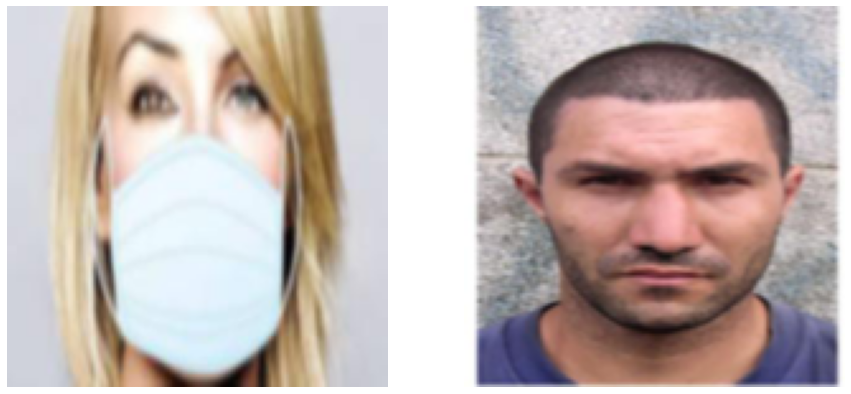

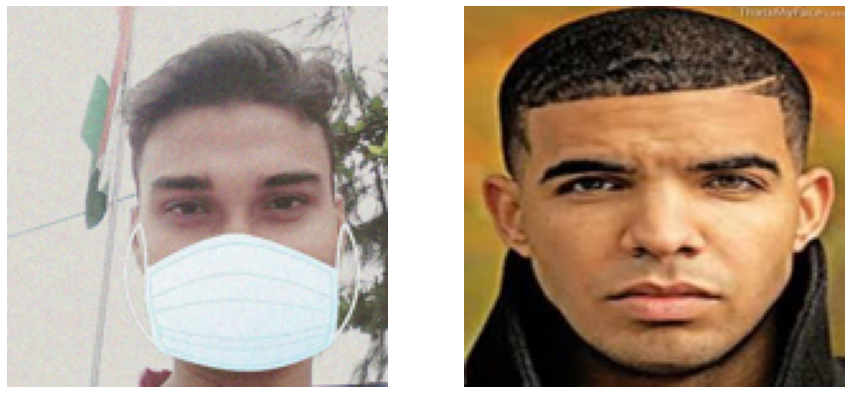

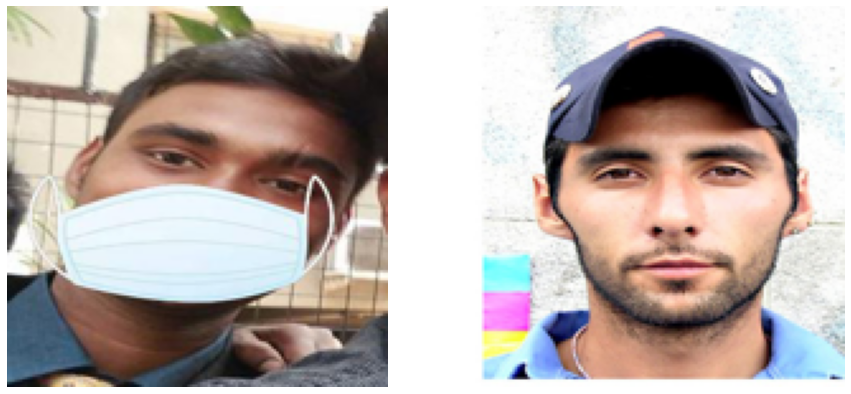

In [9]:
visualize_imgs(df, 5)

In [10]:
df = df.sample(frac = 1)
df.head()

image_path         label
719               /content/dataset/without_mask/176.jpg  without_mask
616        /content/dataset/with_mask/104-with-mask.jpg     with_mask
1103  /content/dataset/without_mask/augmented_image_...  without_mask
1303  /content/dataset/without_mask/augmented_image_...  without_mask
462        /content/dataset/with_mask/193-with-mask.jpg     with_mask

In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.05, random_state=42, shuffle=True)

In [12]:
print("Training Data", train.shape)
print("Test Data", test.shape)

Training Data (1307, 2)
Test Data (69, 2)


In [14]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Input
from keras.models import Model
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

from keras.activations import softmax
from keras.activations import elu
from keras.activations import relu
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.optimizers import SGD, Adam
from keras.layers.normalization import BatchNormalization
import tensorflow as tf

In [15]:
BATCH_SIZE = 4
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = train['label'].nunique()
ES_PATIENCE = 2
RLROP_PATIENCE = 3
DECAY_DROP = 0.5
IMG_DIM = 320

### Data Loaders & Preprocessing

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                    validation_split=0.1, 
                                    horizontal_flip=True)

In [17]:
train_generator = train_datagen.flow_from_dataframe(dataframe=train,
                                                    directory=DATA_DIR,
                                                    x_col="image_path",
                                                    y_col="label",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    target_size=(IMG_DIM, IMG_DIM),
                                                    subset='training',
                                                    shuffle=True
                                                    )

Found 1177 validated image filenames belonging to 2 classes.


In [18]:
valid_generator = train_datagen.flow_from_dataframe(dataframe=train,
                                                    directory=DATA_DIR,
                                                    x_col="image_path",
                                                    y_col="label",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    target_size=(IMG_DIM, IMG_DIM),
                                                    subset='validation',
                                                    shuffle=True
                                                    )

Found 130 validated image filenames belonging to 2 classes.


### Transfer Learning

In [19]:
base_model = tf.keras.applications.Xception(include_top=False,
                                       input_shape=(None, None, 3),
                                       weights='imagenet')
base_model.trainable = False
layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
layer = tf.keras.layers.Dense(1024, activation='relu')(layer)
layer = tf.keras.layers.Dropout(0.5)(layer)
output = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(layer)
model = tf.keras.models.Model(base_model.inputs,output)

83689472/83683744 [==============================] - 0s 0us/step


In [20]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

294 32


In [21]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [22]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
294/294 [==============================] - 91s 186ms/step - loss: 0.1122 - accuracy: 0.9565 - val_loss: 0.0042 - val_accuracy: 1.0000
Epoch 2/40
294/294 [==============================] - 56s 189ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.7537e-04 - val_accuracy: 1.0000
Epoch 3/40
294/294 [==============================] - 55s 188ms/step - loss: 6.7921e-04 - accuracy: 1.0000 - val_loss: 9.0536e-05 - val_accuracy: 1.0000
Epoch 4/40
294/294 [==============================] - 56s 189ms/step - loss: 2.8250e-04 - accuracy: 1.0000 - val_loss: 2.8471e-05 - val_accuracy: 1.0000
Epoch 5/40
112/294 [==========>...................] - ETA: 33s - loss: 1.7265e-04 - accuracy: 1.0000

KeyboardInterrupt: ignored

### Evaluating Model Performance

In [23]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(dataframe=test,
                                                  directory = DATA_DIR,
                                                  x_col="image_path",
                                                  target_size=(HEIGHT, WIDTH),
                                                  batch_size=1,
                                                  shuffle=False,
                                                  class_mode=None)

Found 69 validated image filenames.


In [24]:
import numpy as np

test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


69/69 [==============================] - 2s 14ms/step


In [25]:
true_labels = [0 if x == 'with_mask' else 1 for x in test.label.tolist()]

In [26]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report

print("Accuracy for test: ", round(accuracy_score(true_labels, test_labels), 3))
print("Recall for test: ", round(recall_score(true_labels, test_labels), 3))
print("Precision for test: ", round(precision_score(true_labels, test_labels), 3))
print("------------------------------")
print("Classification Report")
print(classification_report(true_labels, test_labels))

Accuracy for test:  1.0
Recall for test:  1.0
Precision for test:  1.0
------------------------------
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        38

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



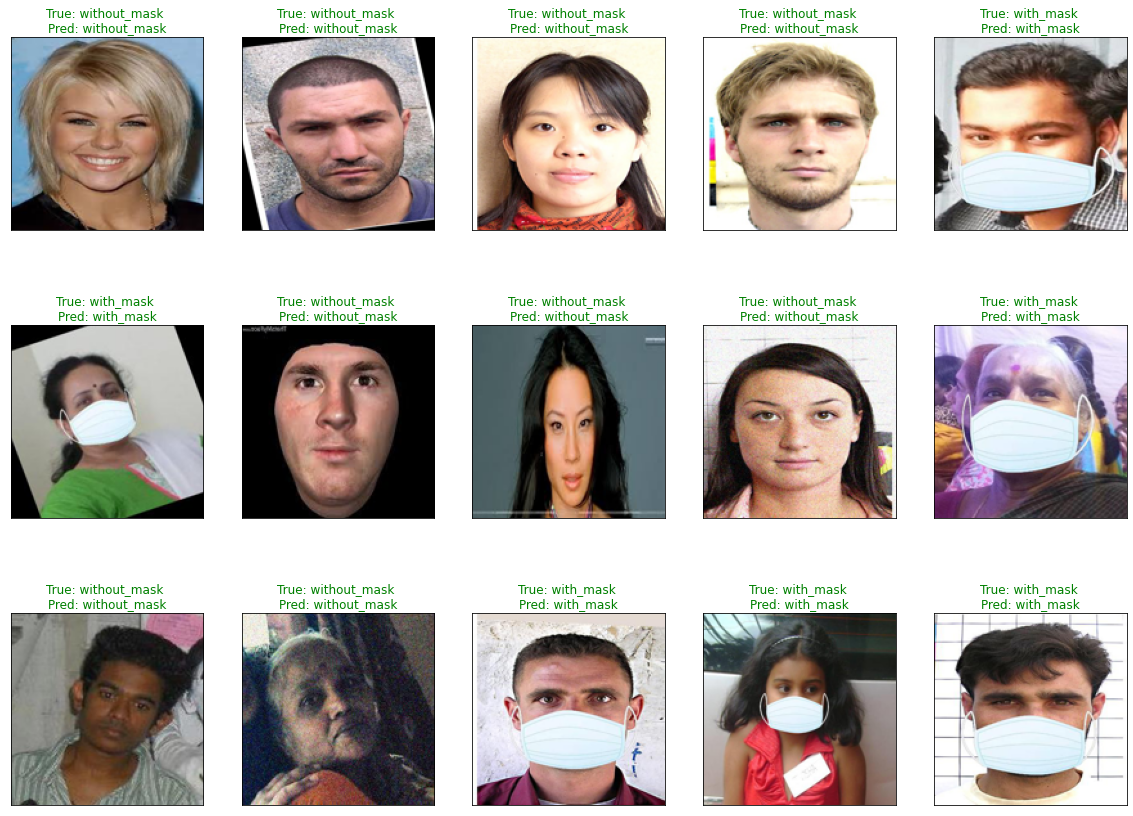

In [27]:
figure = plt.figure(figsize=(20, 15))
for i, index in enumerate(np.random.choice(test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    img = Image.open(test.iloc[index, 0]).resize((150,150))
    ax.imshow(img)
    predict_index = true_labels[index]
    true_index = test_labels[index]
    # Set the title for each image
    title_color = ("green" if predict_index == true_index else "red")
    ax.set_title("True: {} \nPred: {}".format(classes[predict_index], classes[true_index]), color=title_color)
plt.show()

In [40]:
from skimage import io
import warnings
from keras.preprocessing import image

warnings.filterwarnings("ignore")

def predict_image(img_path, model):
  img = image.load_img(img_path, grayscale=False, target_size=(320, 320))
  show_img=image.load_img(img_path, grayscale=False, target_size=(200, 200))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  x /= 255

  custom = model.predict(x)

  x = np.array(x, 'float32')

  plt.gray()
  plt.imshow(show_img)
  plt.xticks([])
  plt.yticks([])

  plt.show()

  objects = ["with_mask", "without_mask"]

  m=-9999
  a=custom[0]
  sorted_a = sorted(a, reverse=True)
  sorted_indx = np.argsort(a)
  sorted_indx = sorted_indx[::-1]

  sorted_labels = [objects[x] for x in sorted_indx]

  for conf, label in zip(sorted_a, sorted_labels):
    print(label, ":", conf*100)

In [42]:
from google.colab import files
fn = files.upload()

Saving 1920x1080 Banner 2.jpg to 1920x1080 Banner 2 (1).jpg
Saving AZ_WASH_Punjab_132.jpg to AZ_WASH_Punjab_132.jpg
Saving Face-Masks-Coronavirus-770x533-1-650x428.jpg to Face-Masks-Coronavirus-770x533-1-650x428 (1).jpg
Saving GetImage.jpg to GetImage.jpg


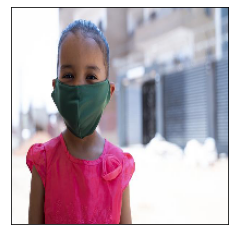

with_mask : 99.99942779541016
without_mask : 0.0005758900897490093


without_mask : 100.0
with_mask : 1.0251462222513053e-10


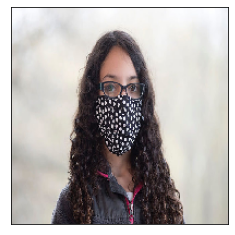

with_mask : 96.40914797782898
without_mask : 3.590850904583931


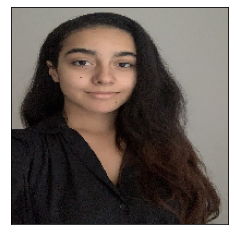

without_mask : 100.0
with_mask : 6.363972543388385e-09


In [43]:
for f in fn.keys():
  file_name = f
  predict_image(file_name, model)

In [95]:
import cv2
import numpy as np

trained_face_data = cv2.CascadeClassifier("/content/haarcascade_frontalface_default.xml")

def detect_faces(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height = image.shape[0]
    width = image.shape[1]
    face_coordinates = trained_face_data.detectMultiScale(image)
    for coordinate in face_coordinates:
        (x, y, w, h) = coordinate
        colors = np.random.randint(1, 255, 3)
        roi = image[y:y+w,x:x+h]
        img_pixels = cv2.resize(roi, (320, 320))
        img_pixels = img_pixels.astype(np.float32)
        img_pixels /= 255
        img_pixels = np.expand_dims(img_pixels, axis = 0)

        predictions = model.predict(img_pixels)
        max_index = np.argmax(predictions[0])
        classes = ('with_mask', 'without_mask')
        predicted_classes = classes[max_index]

        cv2.putText(image, predicted_classes, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
        cv2.rectangle(image, (x, y), (x + w, y + h), (int(colors[0]), int(colors[1]), int(colors[2])), thickness=2)
    image = cv2.resize(image, (width, height))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
    plt.show()

In [96]:
img = cv2.imread("/content/Londonmask1909a.jpg")
detect_faces(img)

In [78]:
from google.colab import files
fn = files.upload()

Saving 914522-face-masks.jpg to 914522-face-masks.jpg
Saving corona-mask-1584669568.jpg to corona-mask-1584669568.jpg
Saving d41586-020-00760-8_17796354.jpg to d41586-020-00760-8_17796354.jpg
Saving Londonmask1909a.jpg to Londonmask1909a.jpg


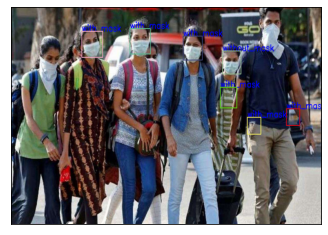

<Figure size 72000x50400 with 0 Axes>

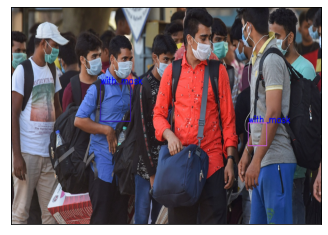

<Figure size 72000x50400 with 0 Axes>

<Figure size 72000x50400 with 0 Axes>

<Figure size 72000x50400 with 0 Axes>

In [88]:
%matplotlib inline

for f in fn.keys():
  file_name = f
  img = cv2.imread(file_name)
  detect_faces(img)

In [97]:
model.save("mask_pred.h5")

### Simple CNN

In [44]:
model_2 = tf.keras.Sequential()

model_2.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(320, 320, 3))) 
model_2.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model_2.add(tf.keras.layers.Dropout(0.3))

model_2.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model_2.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model_2.add(tf.keras.layers.Dropout(0.3))

model_2.add(tf.keras.layers.Flatten())

model_2.add(tf.keras.layers.Dense(256, activation='relu'))
model_2.add(tf.keras.layers.Dropout(0.5))
model_2.add(tf.keras.layers.Dense(2, activation='sigmoid'))

model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 320, 320, 64)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 160, 160, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 160, 160, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 160, 160, 32)      8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 80, 80, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 80, 80, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)

callback_list = [es]
optimizer = Adam(lr=LEARNING_RATE)
model_2.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 320, 320, 64)      832       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 160, 160, 64)      0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 160, 160, 64)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 160, 160, 32)      8224      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 80, 80, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 80, 80, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 204800)           

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model_2.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=EPOCHS,
                              verbose=1,
                              callbacks=callback_list).history

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
294/294 [==============================] - 11s 35ms/step - loss: 0.5563 - accuracy: 0.7553 - val_loss: 0.3518 - val_accuracy: 0.9609
Epoch 2/40
294/294 [==============================] - 11s 36ms/step - loss: 0.2164 - accuracy: 0.9241 - val_loss: 0.2538 - val_accuracy: 0.9688
Epoch 3/40
294/294 [==============================] - 10s 35ms/step - loss: 0.1544 - accuracy: 0.9463 - val_loss: 0.2090 - val_accuracy: 0.9844
Epoch 4/40
294/294 [==============================] - 10s 35ms/step - loss: 0.1051 - accuracy: 0.9616 - val_loss: 0.1385 - val_accuracy: 0.9844
Epoch 5/40
294/294 [==============================] - 10s 35ms/step - loss: 0.0851 - accuracy: 0.9736 - val_loss: 0.1519 - val_accuracy: 0.9844
Epoch 6/40
294/294 [==============================] - 10s 35ms/step - loss: 0.0773 - accuracy: 0.9761 - val_loss: 0.1249 - val_accuracy: 0.9922
Epoch 7/40
294/294 [==============================] - 10s 36ms/step - loss: 0.0687 - accuracy: 0.9778 - val_loss: 0.1118 - val_accuracy:

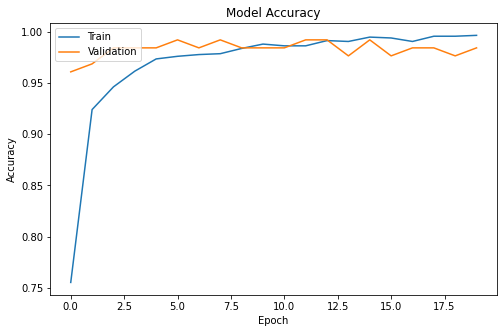

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

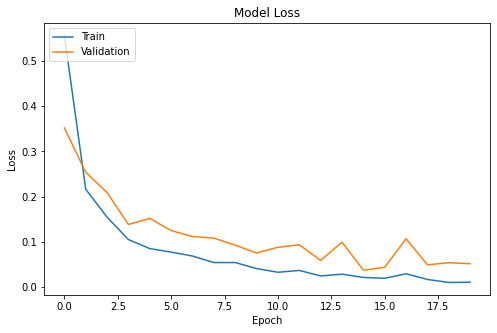

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [ ]:
import numpy as np

test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_preds = model_2.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]
true_labels = [0 if x == 'with_mask' else 1 for x in test.label.tolist()]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


69/69 [==============================] - 0s 5ms/step


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report

print("Accuracy for test: ", round(accuracy_score(true_labels, test_labels), 3))
print("Recall for test: ", round(recall_score(true_labels, test_labels), 3))
print("Precision for test: ", round(precision_score(true_labels, test_labels), 3))
print("------------------------------")
print("Classification Report")
print(classification_report(true_labels, test_labels))

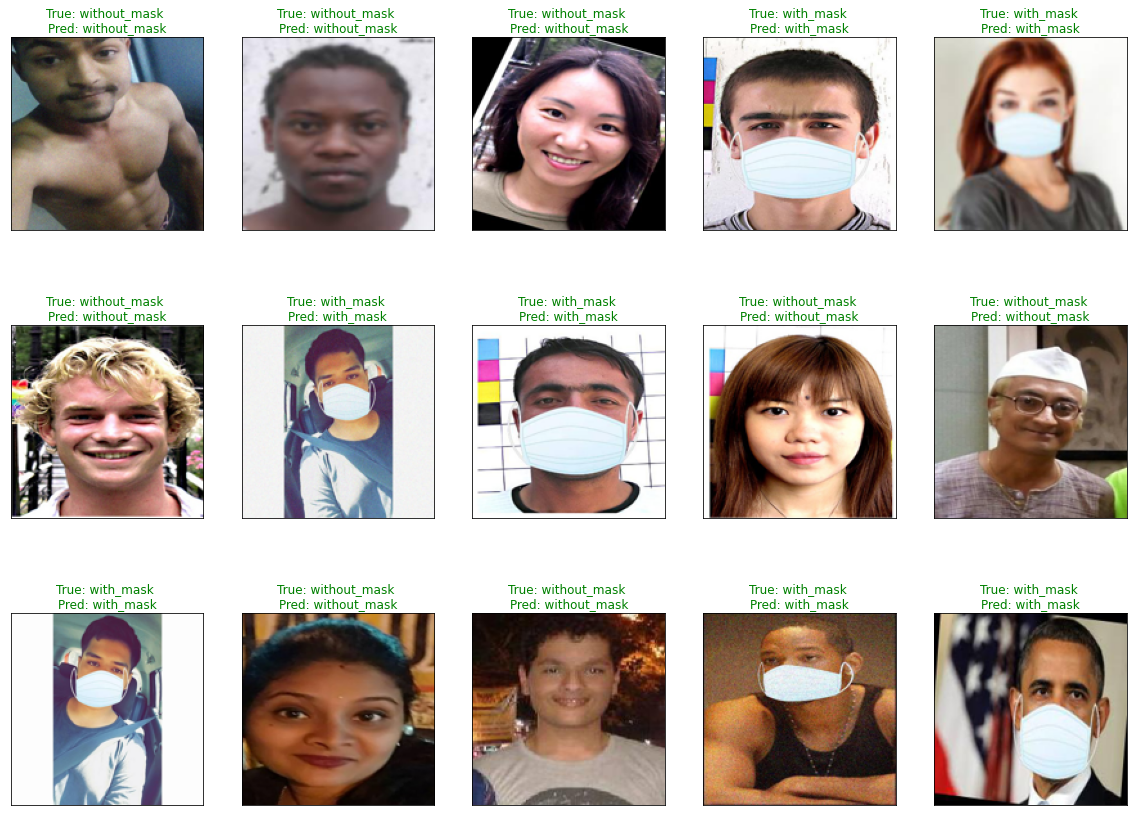

In [ ]:
figure = plt.figure(figsize=(20, 15))
for i, index in enumerate(np.random.choice(test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    img = Image.open(test.iloc[index, 0]).resize((150,150))
    ax.imshow(img)
    predict_index = true_labels[index]
    true_index = test_labels[index]
    # Set the title for each image
    title_color = ("green" if predict_index == true_index else "red")
    ax.set_title("True: {} \nPred: {}".format(classes[predict_index], classes[true_index]), color=title_color)
plt.show()

## Real-time Prediction Verifier

Using the model that we trained, we will open the web cam live with the help of OpenCV and predict the mask/no_mask in real-time.

*** The code below has been tested successfully on my local machine.

In [ ]:
import cv2
import numpy as np
import tensorflow as tf


model_load = tf.keras.models.load_model("mask_pred.h5")

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
cap=cv2.VideoCapture(0)

while True:
    ret,test_img=cap.read()# captures frame and returns boolean value and captured image
    if not ret:
      continue
    gray_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
    faces_detected = face_cascade.detectMultiScale(gray_img, 1.32, 5)
    for (x,y,w,h) in faces_detected:
        cv2.rectangle(test_img,(x,y),(x+w,y+h),(255,0,0),thickness=2)
        roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image
        img_pixels = cv2.cvtColor(roi_gray, cv2.COLOR_GRAY2RGB)
        img_pixels = cv2.resize(img_pixels, (256, 256))
        img_pixels = img_pixels.astype(np.float32)
        img_pixels /= 255
        img_pixels = np.expand_dims(img_pixels, axis = 0)

        predictions = model_load.predict(img_pixels)

        #find max indexed array
        max_index = np.argmax(predictions[0])

        mask = ('male', 'female')
        predicted_mask = mask[max_index]

        cv2.putText(test_img, predicted_mask, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 1)

    resized_img = cv2.resize(test_img, (1000, 700))
    cv2.imshow('mask Prediction ', resized_img)

    if cv2.waitKey(10) == ord('q'):#wait until 'q' key is pressed
        break

cap.release()
cv2.destroyAllWindows

# Task 2 - Mask RCNN

In [98]:
!git clone https://github.com/facebookresearch/Detectron.git

Cloning into 'Detectron'...
remote: Enumerating objects: 1377, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 1377 (delta 1), reused 1 (delta 0), pack-reused 1370
Receiving objects: 100% (1377/1377), 4.38 MiB | 29.93 MiB/s, done.
Resolving deltas: 100% (825/825), done.


In [1]:
cd "/content/Detectron"

/content/Detectron


In [105]:
!pip install -r requirements.txt

     |████████████████████████████████| 256kB 28.6MB/s 
  Created wheel for pyyaml: filename=PyYAML-3.12-cp37-cp37m-linux_x86_64.whl size=43059 sha256=916e3e466ef4adf9a9e409cfa2637f4f9f804b9a5e1459344a1cde240e5ec3c1
  Stored in directory: /root/.cache/pip/wheels/03/05/65/bdc14f2c6e09e82ae3e0f13d021e1b6b2481437ea2f207df3f
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!python setup.py install

Compiling detectron/utils/cython_bbox.pyx because it changed.
Compiling detectron/utils/cython_nms.pyx because it changed.
[1/2] Cythonizing detectron/utils/cython_bbox.pyx
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/Detectron/detectron/utils/cython_bbox.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
[2/2] Cythonizing detectron/utils/cython_nms.pyx
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/Detectron/detectron/utils/cython_nms.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running install
running bdist_egg
running egg_info
creating Detectron.egg-info
writing Detectron.egg-info/PKG-INFO
writing dependency_links to Detectron.egg-info/dependency_links.txt
writin

In [3]:
!wget "https://dl.fbaipublicfiles.com/detectron/36494496/12_2017_baselines/e2e_mask_rcnn_X-101-64x4d-FPN_1x.yaml.07_50_11.fkwVtEvg/output/train/coco_2014_train%3Acoco_2014_valminusminival/generalized_rcnn/model_final.pkl"

--2021-06-02 08:54:12--  https://dl.fbaipublicfiles.com/detectron/36494496/12_2017_baselines/e2e_mask_rcnn_X-101-64x4d-FPN_1x.yaml.07_50_11.fkwVtEvg/output/train/coco_2014_train%3Acoco_2014_valminusminival/generalized_rcnn/model_final.pkl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824223517 (786M) [binary/octet-stream]
Saving to: ‘model_final.pkl’

model_final.pkl     100%[===================>] 786.04M  22.3MB/s    in 36s     

2021-06-02 08:54:48 (21.9 MB/s) - ‘model_final.pkl’ saved [824223517/824223517]



In [7]:
%%bash
make

python setup.py develop --user
running develop
running egg_info
writing Detectron.egg-info/PKG-INFO
writing dependency_links to Detectron.egg-info/dependency_links.txt
writing top-level names to Detectron.egg-info/top_level.txt
adding license file 'LICENSE' (matched pattern 'LICEN[CS]E*')
adding license file 'NOTICE' (matched pattern 'NOTICE*')
writing manifest file 'Detectron.egg-info/SOURCES.txt'
running build_ext
copying build/lib.linux-x86_64-3.7/detectron/utils/cython_bbox.cpython-37m-x86_64-linux-gnu.so -> detectron/utils
copying build/lib.linux-x86_64-3.7/detectron/utils/cython_nms.cpython-37m-x86_64-linux-gnu.so -> detectron/utils
Creating /root/.local/lib/python3.7/site-packages/Detectron.egg-link (link to .)
Adding Detectron 0.0.0 to easy-install.pth file

Installed /content/Detectron
Processing dependencies for Detectron==0.0.0
Finished processing dependencies for Detectron==0.0.0


In [11]:
!python tools/infer_simple.py \
    --cfg configs/12_2017_baselines/e2e_mask_rcnn_R-101-FPN_2x.yaml \
    --output-dir /content/Detectron/demo/output \
    --image-ext jpg \
    --wts https://dl.fbaipublicfiles.com/detectron/35861858/12_2017_baselines/e2e_mask_rcnn_R-101-FPN_2x.yaml.02_32_51.SgT4y1cO/output/train/coco_2014_train:coco_2014_valminusminival/generalized_rcnn/model_final.pkl \
    demo

Found Detectron ops lib: /usr/local/lib/python3.7/dist-packages/torch/lib/libcaffe2_detectron_ops_gpu.so
[E init_intrinsics_check.cc:43] CPU feature avx is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
[E init_intrinsics_check.cc:43] CPU feature avx2 is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
[E init_intrinsics_check.cc:43] CPU feature fma is present on your machine, but the Caffe2 binary is not compiled with it. It means you may not get the full speed of your CPU.
WARNING cnn.py:  25: [====DEPRECATE WARNING====]: you are creating an object from CNNModelHelper class which will be deprecated soon. Please use ModelHelper object with brew module. For more information, please refer to caffe2.ai and python/brew.py, python/brew_test.py for more information.
INFO net.py:  60: Loading weights from: /tmp/detectron-download-cache/3586

The output of the above run on inference images is in pdf format. So converting the pdf pages into jpg images and then, displaying them using matplotlib.

In [17]:
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 154 kB of archives.
After this operation, 613 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 poppler-utils amd64 0.62.0-2ubuntu2.12 [154 kB]
Fetched 154 kB in 0s (350 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../poppler-utils_0.62.0-2ubuntu2.12_amd64.deb ...
Unpacking poppler-utils (0.62.0-2ubuntu2.12) ...
Setting up poppler-utils (0.62.0-2ubuntu2.12) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [15]:
!pip install pdf2image

In [25]:
# import module
from pdf2image import convert_from_path

op_dir = "/content/Detectron/demo/output"
for f in os.listdir(op_dir):
  if f.endswith('.pdf'):
    f_name = f.replace('.jpg.pdf', '')
    f_path = os.path.join(op_dir, f)
    print(f_path)
    # Store Pdf with convert_from_path function
    images = convert_from_path(f_path)
    for i in range(len(images)):
      # Save pages as images in the pdf
      print(f_name+'.jpg')
      images[i].save(os.path.join(op_dir, f_name+'.jpg'), 'JPEG')

/content/Detectron/demo/output/33823288584_1d21cf0a26_k.jpg.pdf
33823288584_1d21cf0a26_k.jpg
/content/Detectron/demo/output/17790319373_bd19b24cfc_k.jpg.pdf
17790319373_bd19b24cfc_k.jpg
/content/Detectron/demo/output/18124840932_e42b3e377c_k.jpg.pdf
18124840932_e42b3e377c_k.jpg
/content/Detectron/demo/output/24274813513_0cfd2ce6d0_k.jpg.pdf
24274813513_0cfd2ce6d0_k.jpg
/content/Detectron/demo/output/19064748793_bb942deea1_k.jpg.pdf
19064748793_bb942deea1_k.jpg
/content/Detectron/demo/output/33887522274_eebd074106_k.jpg.pdf
33887522274_eebd074106_k.jpg
/content/Detectron/demo/output/34501842524_3c858b3080_k.jpg.pdf
34501842524_3c858b3080_k.jpg
/content/Detectron/demo/output/16004479832_a748d55f21_k.jpg.pdf
16004479832_a748d55f21_k.jpg
/content/Detectron/demo/output/15673749081_767a7fa63a_k.jpg.pdf
15673749081_767a7fa63a_k.jpg


19064748793_bb942deea1_k.jpg


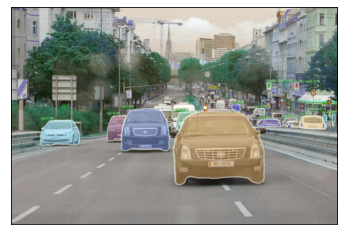

24274813513_0cfd2ce6d0_k.jpg


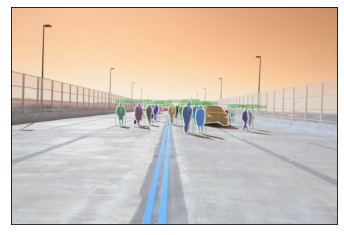

17790319373_bd19b24cfc_k_example_output.jpg


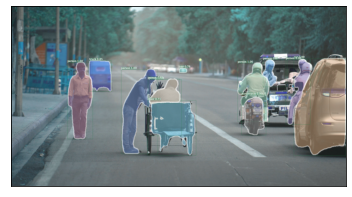

33887522274_eebd074106_k.jpg


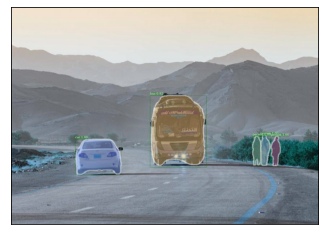

15673749081_767a7fa63a_k.jpg


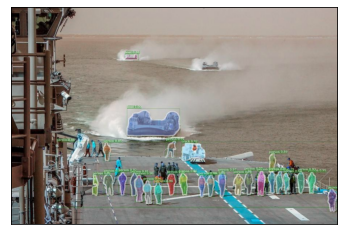

17790319373_bd19b24cfc_k.jpg


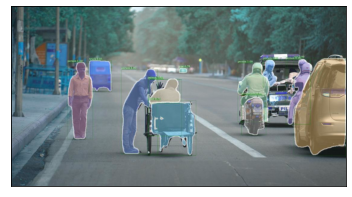

18124840932_e42b3e377c_k.jpg


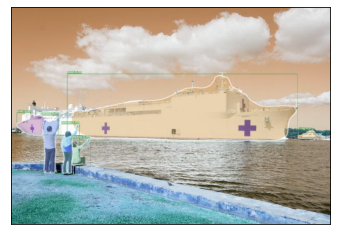

34501842524_3c858b3080_k.jpg


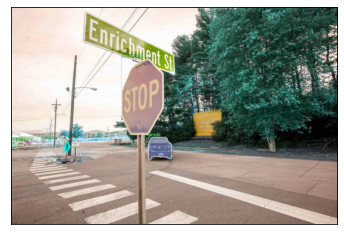

33823288584_1d21cf0a26_k.jpg


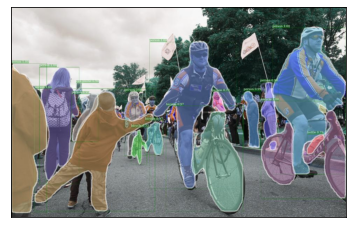

16004479832_a748d55f21_k.jpg


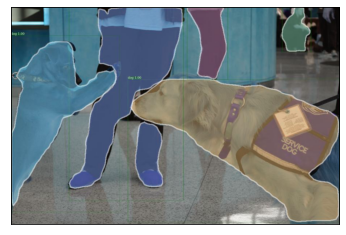

33823288584_1d21cf0a26_k_example_output.jpg


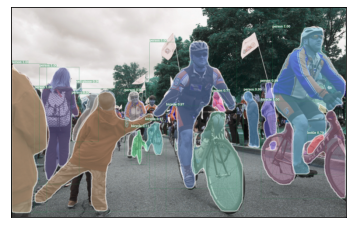

In [26]:
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

op_dir = "/content/Detectron/demo/output"
for f in os.listdir(op_dir):
  if f.endswith('.jpg'):
    print(f)
    f_path = os.path.join(op_dir, f)
    img = cv2.imread(f_path)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.show()